In [1]:
import torch
import pandas as pd
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, RBF
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import train_test_split, KFold
from scipy.optimize import minimize
from sklearn.metrics import r2_score

In [2]:
# Load the MB Model
MB_model = nn.Sequential(
        nn.Linear(5,10),
        nn.ReLU(),
        nn.Linear(10,8),
        nn.ReLU(),
        nn.Linear(8,4),
        nn.ReLU(),
        nn.Linear(4,2)
    )
MB_model.load_state_dict(torch.load("model_total data_v0.pt"))

<All keys matched successfully>

In [3]:
# Load the data
data_path = "C:/Users/USER/Documents/workspace/BMED/DB_bench_BMED_for_LA.xlsx"
raw_Data= pd.read_excel(data_path,sheet_name="revised2")
raw_Data['C_B_LA'] = raw_Data['C_B_LA'].apply(lambda x:0 if x<0 else x)
display(raw_Data[:5])

,T_operation,V_operation,E_operation,t_operation2,C_i,C_F_LA,C_A_LA,C_B_LA,C_F_K,C_A_K,C_B_K,V_F,V_A,V_B,CE,SEC,J_LA,Date,V-C
0,35,35,0.5,2.000000,3.247751,2.666598,0.272588,0.000000,2.179980,0.017253,0.686864,1.08,0.98,1.90,15.522230,6.563329,223.608106,230719,32.605990
1,35,35,0.5,2.933333,3.247751,2.470914,0.577139,0.010599,1.660887,0.027207,1.179806,1.03,1.00,1.93,19.058529,5.408487,543.993190,230719,33.106224
2,35,35,0.5,3.933333,3.247751,2.193242,1.063021,0.023075,1.109295,0.041413,1.734744,0.78,1.15,2.00,26.182700,3.958080,1056.942907,230719,33.869779
3,35,35,0.5,4.933333,3.247751,1.570518,1.593019,0.039529,0.649633,0.034028,2.124536,0.58,1.28,2.10,32.334484,3.211235,1337.426543,230719,35.022501
4,35,35,0.5,5.933333,3.247751,0.258292,2.081178,0.055639,0.096276,0.030335,2.372350,0.28,1.40,2.20,37.264021,2.788854,1432.411229,230719,36.822886


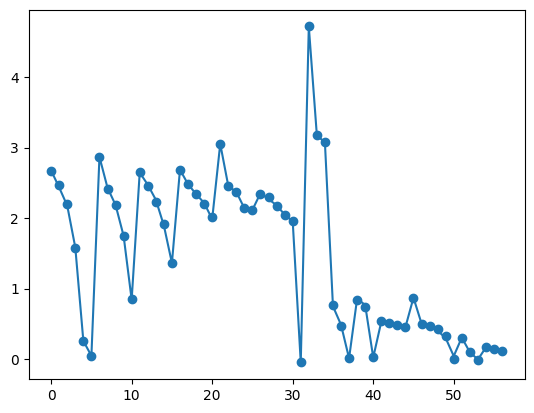

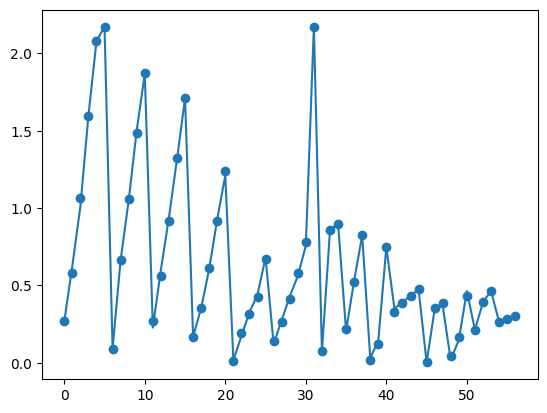

In [4]:
# MB model confirmation
df_MB_columns = ['T_operation','V_operation','E_operation','t_operation2','C_i','C_F_LA','C_A_LA']
df_MB = raw_Data[df_MB_columns]

# Data Set
Xm = df_MB[['T_operation','V_operation','E_operation','t_operation2','C_i']].values
Ym = df_MB[['C_F_LA','C_A_LA']]

X_ts = torch.tensor(Xm, dtype=torch.float32)

dyp = MB_model(X_ts)
dyp_t = dyp.detach().numpy()

CF = np.array([i[4] for i in Xm])-np.array([i[0] for i in dyp_t])
CA = np.array([i[1] for i in dyp_t])
plt.plot(list(range(len(Xm))),CF)
plt.scatter(list(range(len(Xm))),Ym['C_F_LA'])
plt.show()

plt.plot(list(range(len(Xm))),CA)
plt.scatter(list(range(len(Xm))),Ym['C_A_LA'])
plt.show()

In [5]:
# GP model confirmation
df_GP_columns = ['T_operation','V_operation','E_operation','t_operation2','C_i','SEC','J_LA']
df_GP = raw_Data[df_GP_columns]

# Data Set
Xg = df_GP[['T_operation','V_operation','E_operation','t_operation2','C_i']].values
Yg = df_GP[['SEC','J_LA']].values

T, V, E, dt, Ci = [i[0] for i in Xg], [i[1] for i in Xg], [i[2] for i in Xg], [i[3] for i in Xg], [i[4] for i in Xg]
SEC, JLA = [i[0] for i in Yg], [i[1] for i in Yg]

# min-max normalization
mXg = list(range(len(Xg)))
mYg = list(range(len(Yg)))
mCg = list(range(len(CF)))

for i in range(len(mXg)):
    iX = [(T[i]-np.min(T))/(np.max(T)-np.min(T)),(V[i]-np.min(V))/(np.max(V)-np.min(V)),(E[i]-np.min(E))/(np.max(E)-np.min(E)),(dt[i]-np.min(dt))/(np.max(dt)-np.min(dt)),(Ci[i]-np.min(Ci))/(np.max(Ci)-np.min(Ci))]
    iY = [(SEC[i]-np.min(SEC))/(np.max(SEC)-np.min(SEC)),(JLA[i]-np.min(JLA))/(np.max(JLA)-np.min(JLA))]
    iC = [(CF[i]-np.min(CF))/(np.max(CF)-np.min(CF)),(CA[i]-np.min(CA))/(np.max(CA)-np.min(CA))]
    mXg[i], mYg[i], mCg[i] = iX, iY, iC
mX, mY, mC = np.asarray(mXg), np.asarray(mYg), np.asarray(mCg)

In [6]:
# GP model optimization
rs_1 = np.arange(0,100,1)
best_r2_1 = -np.inf
best_r2_2 = -np.inf
best_GPR1 = 0
best_GPR2 = 0
for i in range(len(rs_1)):
    X_train, X_test, Y_train, Y_test = train_test_split(mX, mY, test_size=0.2, random_state=rs_1[i])
    # X_train, X_test, Y_train, Y_test = np.asarray(X_train), np.asarray(X_test), np.asarray(Y_train), np.asarray(Y_test)

    rs_2 = np.arange(0,100,1)
    fun1 = []
    alpha1 = []

    for j in range(len(rs_2)):
        alp = [1e-4,1e-4]
        
        # optimize the parameter alpha of gaussian process regressor
        def alpha_GP1_opt(alp1):
            kfold = KFold(n_splits=5, shuffle=True, random_state= rs_2[j])
            mse_scores_1 = []
            for train_index, test_index in kfold.split(X_train):
                X_train2, X_test2 = X_train[train_index], X_train[test_index]
                Y_train2, Y_test2 = Y_train[train_index], Y_train[test_index]

                GPR1 = GaussianProcessRegressor(alpha=alp1)
                GPR1.fit(X_train2, [j[0] for j in Y_train2])
                ypred1 = GPR1.predict(X_test2)

                mse_1 = mse(np.asarray([j[0] for j in Y_test2]),ypred1)
                mse_scores_1.append(mse_1)
            
            return sum(mse_scores_1) / len(mse_scores_1)
        
        res1 = minimize(alpha_GP1_opt,alp[0],bounds=[(1e-10,10)])
        alpha1.append(res1.x)
        fun1.append(res1.fun)

    fun2 = []
    alpha2 = []
    for j in range(len(rs_2)):
        def alpha_GP2_opt(alp2):
            kfold = KFold(n_splits=5, shuffle=True, random_state= rs_2[j])
            mse_scores_2 = []
            for train_index, test_index in kfold.split(X_train):
                X_train2, X_test2 = X_train[train_index], X_train[test_index]
                Y_train2, Y_test2 = Y_train[train_index], Y_train[test_index]

                GPR2 = GaussianProcessRegressor(alpha=alp2)
                GPR2.fit(X_train2, [j[1] for j in Y_train2])
                ypred2 = GPR2.predict(X_test2)

                mse_2 = mse(np.asarray([j[1] for j in Y_test2]),ypred2)
                mse_scores_2.append(mse_2)
            
            return sum(mse_scores_2) / len(mse_scores_2)


        res2 = minimize(alpha_GP2_opt,alp[1],bounds=[(1e-10,10)])
        alpha2.append(res2.x)
        fun2.append(res2.fun)
    fun1 = np.asarray(fun1)
    fun2 = np.asarray(fun2)
    fun_min = np.argmin(fun1*fun2)
    alp1_opt = alpha1[fun_min]
    alp2_opt =  alpha2[fun_min] 

    GPR1f = GaussianProcessRegressor(alpha=alp1_opt)
    GPR1f.fit(X_train, [i[0] for i in Y_train])
    ypred1,_ = GPR1f.predict(X_test,[i[0] for i in Y_test])

    GPR2f = GaussianProcessRegressor(alpha=alp2_opt)
    GPR2f.fit(X_train, [i[1] for i in Y_train])
    ypred2,_ = GPR2f.predict(X_test,[i[1] for i in Y_test])

    r2_1 = r2_score([i[0] for i in Y_test],ypred1)
    r2_2 = r2_score([i[1] for i in Y_test],ypred2)

    if best_r2_1 < r2_1:
        best_r2_1 = r2_1
        best_GPR1 = GPR1f
        print(f'GPR1 update! R2 = {r2_1}')
    if best_r2_2 < r2_2:
        best_r2_2 = r2_2
        best_GPR2 = GPR2f
        print(f'GPR2 update! R2 = {r2_2}')
    print(f'Iteration:{i}/{200}')




KeyboardInterrupt: 

In [7]:
# GP model optimization _ Total Regression
rs_1 = np.arange(0,200,1)
best_r2_1 = -np.inf
best_r2_2 = -np.inf
best_GPR1 = 0
best_GPR2 = 0
for i in range(len(rs_1)):
    X_train, X_test, Y_train, Y_test = train_test_split(mX, mY, test_size=0.2, random_state=rs_1[i])
    # X_train, X_test, Y_train, Y_test = np.asarray(X_train), np.asarray(X_test), np.asarray(Y_train), np.asarray(Y_test)

    rs_2 = np.arange(0,200,1)
    fun1 = []
    alpha1 = []

    for j in range(len(rs_2)):
        alp = [1e-4,1e-4]
        
        # optimize the parameter alpha of gaussian process regressor
        def alpha_GP1_opt(alp1):
            kfold = KFold(n_splits=5, shuffle=True, random_state= rs_2[j])
            mse_scores_1 = []
            for train_index, test_index in kfold.split(X_train):
                X_train2, X_test2 = X_train[train_index], X_train[test_index]
                Y_train2, Y_test2 = Y_train[train_index], Y_train[test_index]

                GPR1 = GaussianProcessRegressor(alpha=alp1)
                GPR1.fit(X_train2, [j[0] for j in Y_train2])
                ypred1 = GPR1.predict(X_test2)

                mse_1 = mse(np.asarray([j[0] for j in Y_test2]),ypred1)
                mse_scores_1.append(mse_1)
            
            return sum(mse_scores_1) / len(mse_scores_1)
        
        res1 = minimize(alpha_GP1_opt,alp[0],bounds=[(1e-10,10)])
        alpha1.append(res1.x)
        fun1.append(res1.fun)

    fun2 = []
    alpha2 = []
    for j in range(len(rs_2)):
        def alpha_GP2_opt(alp2):
            kfold = KFold(n_splits=5, shuffle=True, random_state= rs_2[j])
            mse_scores_2 = []
            for train_index, test_index in kfold.split(X_train):
                X_train2, X_test2 = X_train[train_index], X_train[test_index]
                Y_train2, Y_test2 = Y_train[train_index], Y_train[test_index]

                GPR2 = GaussianProcessRegressor(alpha=alp2)
                GPR2.fit(X_train2, [j[1] for j in Y_train2])
                ypred2 = GPR2.predict(X_test2)

                mse_2 = mse(np.asarray([j[1] for j in Y_test2]),ypred2)
                mse_scores_2.append(mse_2)
            
            return sum(mse_scores_2) / len(mse_scores_2)


        res2 = minimize(alpha_GP2_opt,alp[1],bounds=[(1e-10,10)])
        alpha2.append(res2.x)
        fun2.append(res2.fun)
    fun1 = np.asarray(fun1)
    fun2 = np.asarray(fun2)
    fun_min1 = np.argmin(fun1)
    fun_min2 = np.argmin(fun2)
    alp1_opt = alpha1[fun_min1]
    alp2_opt =  alpha2[fun_min2] 

    GPR1f = GaussianProcessRegressor(alpha=alp1_opt)
    GPR1f.fit(X_train, [i[0] for i in Y_train])
    ypred1,_ = GPR1f.predict(mX,[i[0] for i in mY])

    GPR2f = GaussianProcessRegressor(alpha=alp2_opt)
    GPR2f.fit(X_train, [i[1] for i in Y_train])
    ypred2,_ = GPR2f.predict(mX,[i[1] for i in mY])

    r2_1 = r2_score([i[0] for i in mY],ypred1)
    r2_2 = r2_score([i[1] for i in mY],ypred2)

    if best_r2_1 < r2_1:
        best_r2_1 = r2_1
        best_GPR1 = GPR1f
        print(f'GPR1 update! R2 = {r2_1}')
    if best_r2_2 < r2_2:
        best_r2_2 = r2_2
        best_GPR2 = GPR2f
        print(f'GPR2 update! R2 = {r2_2}')
    print(f'Iteration:{i}/{200}')




GPR1 update! R2 = 0.626049562685306
GPR2 update! R2 = 0.7138979262029486
Iteration:0/200
Iteration:1/200
GPR1 update! R2 = 0.7337782622009794
GPR2 update! R2 = 0.7399645182355489
Iteration:2/200
Iteration:3/200
Iteration:4/200
GPR2 update! R2 = 0.7558091805983836
Iteration:5/200
GPR1 update! R2 = 0.7556147309436471
Iteration:6/200
Iteration:7/200
GPR2 update! R2 = 0.8051199344523747
Iteration:8/200
Iteration:9/200
Iteration:10/200
Iteration:11/200
Iteration:12/200
Iteration:13/200
Iteration:14/200
Iteration:15/200
Iteration:16/200
GPR1 update! R2 = 0.7623357400335358
Iteration:17/200
Iteration:18/200
Iteration:19/200
Iteration:20/200
Iteration:21/200
Iteration:22/200
Iteration:23/200
GPR1 update! R2 = 0.7638658710300752
Iteration:24/200
Iteration:25/200
Iteration:26/200
Iteration:27/200
Iteration:28/200
Iteration:29/200
Iteration:30/200
Iteration:31/200
Iteration:32/200
Iteration:33/200
Iteration:34/200
Iteration:35/200
Iteration:36/200
Iteration:37/200
Iteration:38/200
Iteration:39/20

r2_1:0.7644505453433776, r2_2:0.8179218017633755


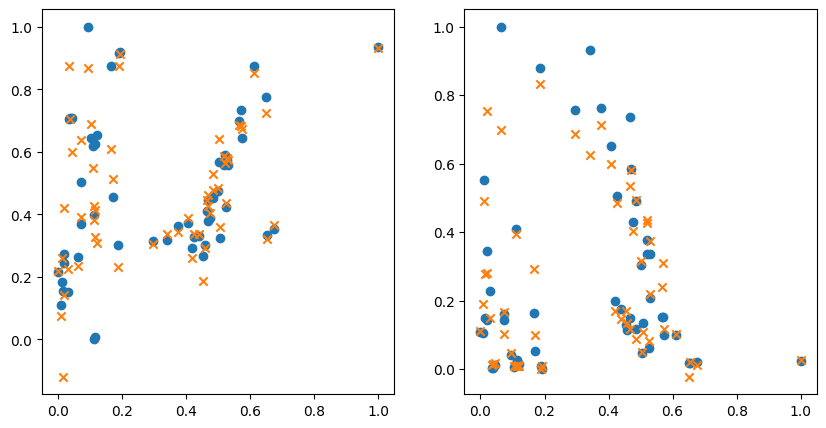

In [8]:
yt1,_ = best_GPR1.predict(mX,[i[0] for i in mY])
yt2,_ = best_GPR2.predict(mX,[i[1] for i in mY])

fig, axs = plt.subplots(1,2, figsize =(10,5))

axs[0].scatter([i[0] for i in mC],[i[0] for i in mY],marker='o')
axs[0].scatter([i[0] for i in mC],yt1,marker='x')

axs[1].scatter([i[0] for i in mC],[i[1] for i in mY],marker='o')
axs[1].scatter([i[0] for i in mC],yt2,marker='x')

r2_1 = r2_score([i[0] for i in mY],yt1)
r2_2 = r2_score([i[1] for i in mY],yt2)
print(f'r2_1:{r2_1}, r2_2:{r2_2}')